# PGD Attack and Binary Input Detector Using MNIST10

This notebook shows the **Projected Gradient Descent** attack implmentation using the ART library against deep learning models trained on MNIST-10 dataset. The notebook covers the following:

* Load the required libariries
* Load the dataset and inspect the data
* Create a deep learning model
* Train and evaluate the deep learning model on CIFAR test data
* Create an ART Keras classifier.
* Implement PGD attack using ART
* Create adversarial samples using the PDG attack
* Evaluate the deep leaarning model against the adversarial samples
* Create a detector model to detect adversarial samples
* Train and evaluate the detector model

### **Projected Gradient Descent (PGD) Attack - Overview**


The Projected Gradient Descent (PGD) attack is a popular method used to generate adversarial examples for neural networks, particularly for tasks like image classification. It belongs to the family of **iterative attacks**, meaning that instead of just perturbing the input once, it repeatedly refines the perturbation to gradually mislead the model. PGD is often considered a more robust attack than the simple Fast Gradient Sign Method (FGSM) because it involves multiple steps, allowing for more powerful adversarial examples.

**Key Concepts:**

* **Adversarial Example:** A modified input that is designed to cause the model to make an incorrect prediction.
* **Adversarial Perturbation:** A small change to the original input that makes the model misclassify it.
* **Projected Gradient Descent (PGD):** An iterative method that modifies the input by applying gradient-based steps and then projects it back to a feasible region to ensure the perturbation is constrained.

**Steps in PGD Attack**

The core idea behind PGD is to iteratively update the input using the **gradient of the loss function** with respect to the input, ensuring that each update stays within a certain bound (usually the $ℓ_{∞}$​-norm).

**1. Initialization:**

PGD starts with an input $x_{0}$​ (the original image) and adds a small random noise to it, creating an initial perturbed input $x_{0}+δ_{0}​$. The perturbation is bounded by a maximum allowed norm (usually the $ℓ∞$​-norm).

**2. Gradient Step:**

In each iteration, the attack computes the gradient of the loss with respect to the input. The model’s loss function is usually a cross-entropy loss for classification tasks. The goal is to maximize this loss to mislead the classifier, so the gradient is computed in the direction that increases the loss.

**3. Update Rule:**

Each iteration updates the perturbation based on the gradient:
$$x_{t+1}=Proj_{B_{(x0,ϵ)}}(xt+α⋅sign(∇_{x}J(xt,y)))$$

Where:

- $x_{t}$​ is the perturbed input at the $t-th$ iteration.
- $α$ is the step size or learning rate for each update (determines how big the update should be).
- $∇_{x}J(xt,y)$ is the gradient of the loss function $J$ with respect to the input $x$ (i.e., how the model's loss changes as the input changes).
- $sign(∇_{x}J(xt,y))$ is the element-wise sign of the gradient, which ensures the perturbation moves in the direction that maximizes the loss.
- $Proj_{B_{(x0,ϵ)}}$​ is the projection operation that ensures the perturbation stays within the allowed perturbation norm. Here, $B_{(x0,ϵ)}$ is the ball of radius $ϵ$ around the original input $x_{0}​$, typically defined using the $ℓ$∞​-norm.

**4. Projection:**

After each update, we project the perturbed input back into a ball of radius $ϵ$ around the original input. This ensures that the adversarial example is not too different from the original input in terms of the allowed perturbation. The projection operator essentially clamps each pixel’s value to lie within the valid range of the image and ensures that the perturbation does not exceed the allowed ϵ-radius.

**5. Repeat:**

Steps 2 to 4 are repeated for a fixed number of iterations $T$, or until the attack succeeds in fooling the model.
Formula Breakdown

Let's break down the formula into its components:
$$x_{t+1}=Proj_{B_{(x0,ϵ)}}(x_{t}+α⋅sign(∇_{x}J(x_{t},y)))$$

- $sign(∇_{x}J(x_{t},y))$: This part calculates the direction of the gradient of the loss with respect to the input $x$. The sign operation ensures that the perturbation only moves in the direction of the steepest increase in the loss function.

- $α⋅sign(∇_{x}J(x_{t},y))$: The step size $α$ controls how large the perturbation should be at each step. This can be adjusted to make the attack stronger or weaker.

- $x_{t}+α⋅sign(∇_{x}J(x_{t},y))$: This updates the perturbed image by adding the gradient-based perturbation to the current image $x_{t}$​.

- $Proj_{B_{(x0,ϵ)}}$: The projection operation ensures that the perturbation does not exceed the allowed $ℓ∞$-norm bound. The adversarial example must remain close to the original input, within a radius ϵϵ, where ϵϵ is the maximum allowed perturbation.
    - $B(x_{0},ϵ)$ is a ball of radius $ϵ$ centered at $x_{0}$​ in the input space.
    - This projection typically clips the perturbed image values so that they remain within the valid range of pixel values (e.g., [0, 255] for image pixels).

**How PGD Works During the Attack**

1. **Start:** Initialize the perturbed image $x_{0}+δ_{0}$​, where $δ_{0}$​ is a small random perturbation added to the original input $x_{0}$.

2. **Iterative Steps:**
    - For each iteration, compute the gradient of the loss function with respect to the current perturbed image $x_{t}$​, i.e., $∇_{x}J(x_{t},y)$.
    - Update the perturbed image $x_{t}$​ by adding the gradient’s sign, scaled by a step size $α$.
    - Project the updated image back into the $ϵ$-ball around the original image to ensure the perturbation does not exceed the allowable bound.

3. **End:** After a fixed number of iterations or when the attack succeeds in fooling the classifier, stop. The final perturbed image $x_{T}$​ is the adversarial example.

**Strengths of PGD**

* **Stronger Attack:** Since PGD uses multiple iterations, it can generate stronger adversarial examples compared to single-step methods like FGSM.
* **Versatility:** PGD works with various types of loss functions, making it applicable to a wide range of tasks and models.
* **Robustness:** It is often more successful in fooling models, as the iterative refinement allows the attack to find more subtle and effective perturbations.


## Install and import required Libraries

In [1]:
# Install prerequired libraries.
# !pip install adversarial-robustness-toolbox

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt
# import pandas as pd

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.detector.evasion import BinaryInputDetector

2025-01-13 13:56:48.448944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-13 13:56:48.546011: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load MNIST dataset

In [3]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = np.load('./../Datasets/mnist10_dataset.npy', allow_pickle = True)
x_train, x_test = x_train / 255.0, x_test/ 255.0
min = x_train.min()
max = x_train.max()
x_train.shape, y_train.shape, x_test.shape, y_test.shape, min, max

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,), 0.0, 1.0)

## Inpect the data


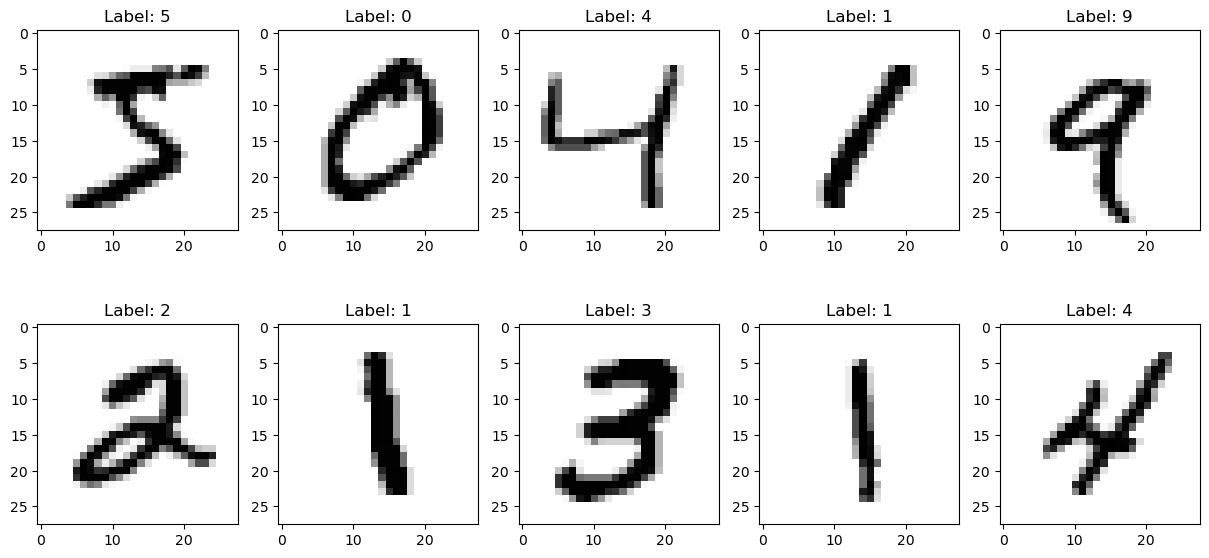

In [9]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_train[:10], y_train[:10])):
  im_idx = np.argwhere(y_train == i)[0]
  ax[i].imshow(image, cmap='gray_r')
  ax[i].set_title(f"Label: {label}",  fontsize=12)

In [10]:
nb_classes =10
y_test = tf.keras.utils.to_categorical(y_test, num_classes=nb_classes)
x_test = np.expand_dims(x_test, axis=-1)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_classes)
x_train = np.expand_dims(x_train, axis=-1)

## TensorFlow with Keras API

Create a model using Keras API. Here we use the Keras Sequential model and add a sequence of layers. Afterwards the model is compiles with optimizer, loss function and metrics.

In [2]:
model = tf.keras.models.Sequential([
    # tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

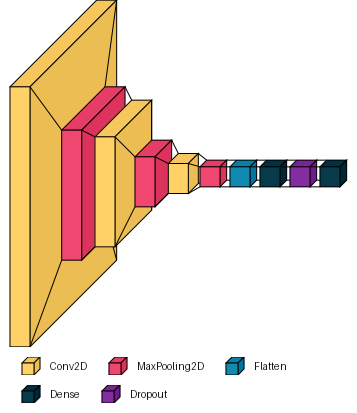

In [3]:
import visualkeras
visualkeras.layered_view(model, scale_xy=10, legend=True)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

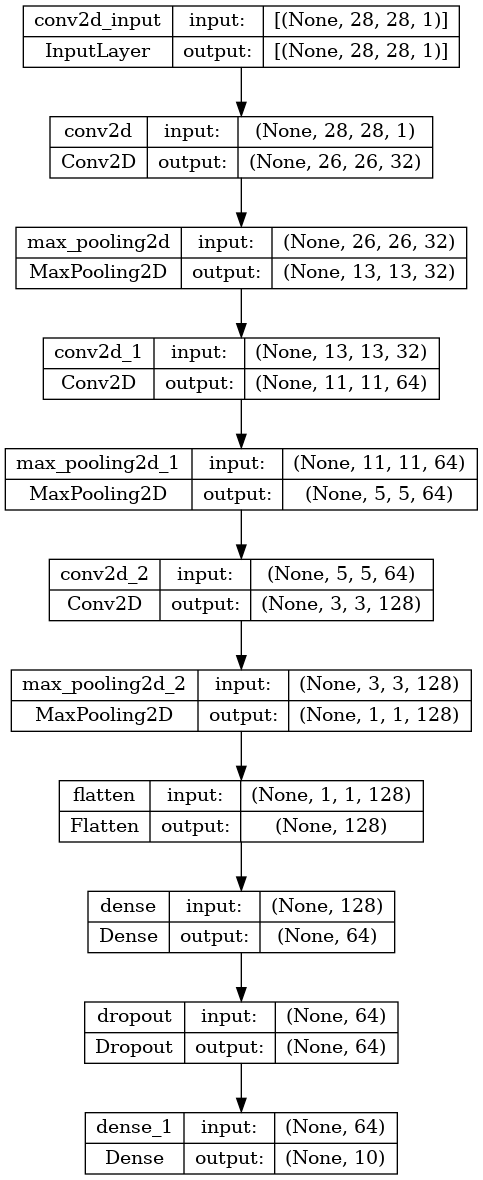

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Training the model

In [15]:
history = model.fit(x_train, y_train, epochs = 3)

Train on 60000 samples


2025-01-13 11:45:51.452005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-13 11:45:52.204761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12999 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:d5:00.0, compute capability: 8.6
2025-01-13 11:45:52.205954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18484 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:17:00.0, compute capability: 7.5
2025-01-13 11:45:52.207142: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:loca

Epoch 1/3


2025-01-13 11:45:52.822119: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/conv2d_2/kernel/m/Assign' id:351 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d_2/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d_2/kernel/m, training/Adam/conv2d_2/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-13 11:45:53.358767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2025-01-13 11:45:53.982759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


60000/60000 [==============================] - 36s 606us/sample - loss: 0.2382 - accuracy: 0.9261
Epoch 2/3
60000/60000 [==============================] - 36s 594us/sample - loss: 0.0793 - accuracy: 0.9768
Epoch 3/3
60000/60000 [==============================] - 35s 580us/sample - loss: 0.0575 - accuracy: 0.9832


## Evaluate model accuracy on test data.

In [18]:
# model.save('./../Models/mnist10_model.keras')
model = tf.keras.models.load_model('./../Models/mnist10_model.keras')
model.summary()

2025-01-13 11:48:41.074246: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1_1/kernel/Assign' id:652 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1_1/kernel, dense_1_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-13 11:48:41.386798: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_3/kernel/v/Assign' id:865 op device:{requested: '', assigned: ''} def:{{{node conv2d_3/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_3/kernel/v, conv2d_3/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

In [19]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2025-01-13 11:48:54.094342: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:780 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy on test data: 98.73%


In [20]:
# The number of test samples are 10000 but we are going to take a small portion of it.
x_test = x_test[0:500]
y_test = y_test[0:500]

## Create a ART Keras classifier for the TensorFlow Keras model.

In [21]:
classifier = KerasClassifier(model=model, clip_values=(min, max))

# **Projected Gradient Descent (PGD)**

> class art.attacks.evasion.ProjectedGradientDescent(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE | OBJECT_DETECTOR_TYPE, norm: int | float | str = inf, eps: int | float | ndarray = 0.3, eps_step: int | float | ndarray = 0.1, decay: float | None = None, max_iter: int = 100, targeted: bool = False, num_random_init: int = 0, batch_size: int = 32, random_eps: bool = False, summary_writer: str | bool | SummaryWriter = False, verbose: bool = True)

The Projected Gradient Descent attack is an iterative method in which, after each iteration, the perturbation is projected on an lp-ball of specified radius (in addition to clipping the values of the adversarial sample so that it lies in the permitted data range). This is the attack proposed by Madry et al. for adversarial training.
* Paper link: https://arxiv.org/abs/1706.06083

*\_\_init__(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE | OBJECT_DETECTOR_TYPE, norm: int | float | str = inf, eps: int | float | ndarray = 0.3, eps_step: int | float | ndarray = 0.1, decay: float | None = None, max_iter: int = 100, targeted: bool = False, num_random_init: int = 0, batch_size: int = 32, random_eps: bool = False, summary_writer: str | bool | SummaryWriter = False, verbose: bool = True)*

**Create a ProjectedGradientDescent instance.**

    Parameters:
* estimator – An trained estimator.
* norm – The norm of the adversarial perturbation supporting “inf”, np.inf, 1 or 2.
* eps – Maximum perturbation that the attacker can introduce.
* eps_step – Attack step size (input variation) at each iteration.
* random_eps (bool) – When True, epsilon is drawn randomly from truncated normal distribution. The literature suggests this for FGSM based training to generalize across different epsilons. eps_step is modified to preserve the ratio of eps / eps_step. The effectiveness of this method with PGD is untested (https://arxiv.org/pdf/1611.01236.pdf).
* decay – Decay factor for accumulating the velocity vector when using momentum.
* max_iter (int) – The maximum number of iterations.
* targeted (bool) – Indicates whether the attack is targeted (True) or untargeted (False).
* num_random_init (int) – Number of random initialisations within the epsilon ball. For num_random_init=0 starting at the original input.
* batch_size (int) – Size of the batch on which adversarial samples are generated.
* summary_writer – Activate summary writer for TensorBoard. Default is False and deactivated summary writer. If True save runs/CURRENT_DATETIME_HOSTNAME in current directory. If of type str save in path. If of type SummaryWriter apply provided custom summary writer. Use hierarchical folder structure to compare between runs easily. e.g. pass in ‘runs/exp1’, ‘runs/exp2’, etc. for each new experiment to compare across them.
* verbose (bool) – Show progress bars.

    
**generate(x: ndarray, y: ndarray | None = None, \*\*kwargs) → ndarray**
Generate adversarial samples and return them in an array.
    
    
    Return type:
* ndarray
    
    
    Parameters:
* x (ndarray) – An array with the original inputs.
* y – Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape (nb_samples,). Only provide this parameter if you’d like to use true labels when crafting adversarial samples. Otherwise, model predictions are used as labels to avoid the “label leaking” effect (explained in this paper: https://arxiv.org/abs/1611.01236). Default is None.
* mask (np.ndarray) – An array with a mask broadcastable to input x defining where to apply adversarial perturbations. Shape needs to be broadcastable to the shape of x and can also be of the same shape as x. Any features for which the mask is zero will not be adversarially perturbed.


    Returns:
* An array holding the adversarial examples.

    
**set_params(\*\*kwargs) → None**

Take in a dictionary of parameters and apply attack-specific checks before saving them as attributes.

    Parameters:
* kwargs – A dictionary of attack-specific parameters.

    
    property summary_writer
* The summary writer.

Link: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#projected-gradient-descent-pgd



## Create a ART Projected Gradient Descent attack.

In [22]:
# eps – defines the attack step size (input variation). The smaller the eps, the little the attack scale would be.
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.2)

Generate adversarial test data.

In [23]:
x_test_adv = attack_pgd.generate(x_test)

2025-01-13 11:52:17.886423: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1_1/Softmax' id:663 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [61]:
# np.savez('./pgd_generated_data/pgd_detector_generated_MNIST10_test.npz', 
#          x_test_adv=x_test_adv, y_test_adv = y_test)

# x_test_data = np.load('./pgd_generated_data/pgd_detector_generated_MNIST10_test.npz')
# x_test_adv, y_test = x_test_data['x_test_adv'], x_test_data['y_test_adv']
# x_test_adv.shape, y_test.shape

((500, 28, 28, 1), (500, 10))

## Visualize the first adversarial samples.

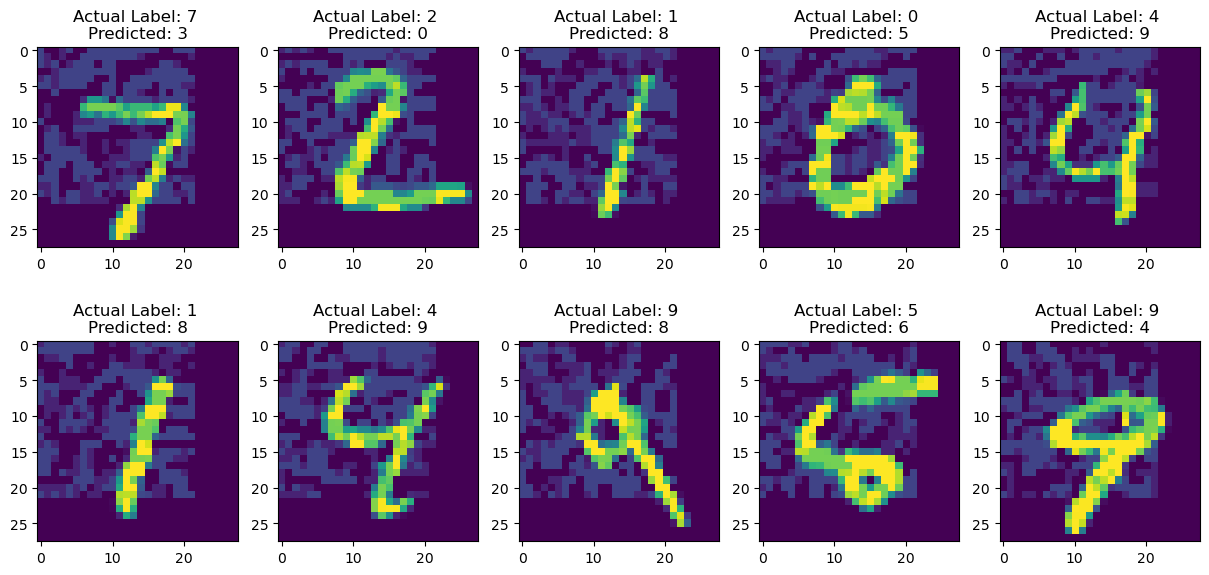

In [24]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_test_adv[:10], y_test[:10])):
  #im_idx = np.argwhere(y_train == i)[0]
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {label.argmax()} \nPredicted: {model.predict(np.expand_dims(image, axis=0)).argmax()}",  fontsize=12)


## Evaluate the trained model

In [25]:
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 4.60%
Average perturbation: 0.07


<br>

# Training the adversarial sample detector

In [27]:
# creating new adversarial using the pgd.
# we combine the generated adversarial images with the same number of images from the dataset and label them as [1, 0]
x_train_adv = attack_pgd.generate(x_train[:500])
nb_train = x_train[:500].shape[0]

x_train_detector = np.concatenate((x_train[:500], x_train_adv), axis=0)
y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

## Save/load the the adversarial samples

In [28]:
# np.savez('./pgd_generated_data/pgd_detector_generated_MNIST10.npz', 
#          x_train_detector=x_train_detector, y_train_detector = y_train_detector)

In [29]:
# detector_data = np.load('./pgd_generated_data/pgd_detector_generated_MNIST10.npz')
# x_train_detector, y_train_detector= detector_data['x_train_detector'], detector_data['y_train_detector']
x_train_detector.shape, y_train_detector.shape

((1000, 28, 28, 1), (1000, 2))

## Train and evaluate the detector model

In [30]:
detector_model = tf.keras.models.Sequential([
    # tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

detector_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']);

In [31]:
history = detector_model.fit(x_train_detector, y_train_detector, epochs = 3)

Train on 1000 samples
Epoch 1/3


2025-01-13 12:43:10.537026: W tensorflow/c/c_api.cc:291] Operation '{name:'training_2/Adam/dense_3/kernel/v/Assign' id:1527 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_3/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_3/kernel/v, training_2/Adam/dense_3/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1000/1000 [==============================] - 1s 941us/sample - loss: 0.4492 - accuracy: 0.8040
Epoch 2/3
1000/1000 [==============================] - 1s 644us/sample - loss: 0.0183 - accuracy: 0.9980
Epoch 3/3
1000/1000 [==============================] - 1s 642us/sample - loss: 0.0023 - accuracy: 0.9990


In [35]:
# Save and load the detector model
path = './models/PGD_detector_model_mnist10.keras'
# detector_model.save(path)
detector_model =tf.keras.models.load_model(path)
detector_model.summary()

2025-01-13 12:57:45.812377: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_5_1/bias/Assign' id:1695 op device:{requested: '', assigned: ''} def:{{{node conv2d_5_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_5_1/bias, conv2d_5_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-13 12:57:46.216799: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_3_2/bias/v/Assign' id:1968 op device:{requested: '', assigned: ''} def:{{{node conv2d_3_2/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_3_2/bias/v, conv2d_3_2/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trig

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 128)       

In [36]:
# creating the test samples using the previous created adversarial images with same number of images from the test_split
nb_test = x_test.shape[0]

x_test_detector = np.concatenate((x_test, x_test_adv), axis=0)
y_test_detector = np.concatenate((np.array([[1,0]]*nb_test), np.array([[0,1]]*nb_test)), axis=0)

Evaluat the result

In [37]:
loss_test, accuracy_test = detector_model.evaluate(x_test_detector, y_test_detector)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2025-01-13 12:57:55.984153: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_3/mul' id:1878 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy on test data: 99.80%


In [38]:
detector_classifier = KerasClassifier(clip_values=(0.0, 0.1), model=detector_model, use_logits=False)
detector = BinaryInputDetector(detector_classifier)

In [39]:
detector.fit(x_train_detector, y_train_detector, nb_epochs=3, batch_size=32)

2025-01-13 12:58:06.799062: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_3/mul' id:1878 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


## Evaluating the detector

Apply the detector to the adversarial test data:

In [40]:
_, is_adversarial = detector.detect(x_test_adv)
flag_adv = np.sum(is_adversarial)

print("Adversarial test data (first 100 images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(1000 - flag_adv))

2025-01-13 12:58:34.498396: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_3_1/Softmax' id:1761 op device:{requested: '', assigned: ''} def:{{{node dense_3_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Adversarial test data (first 100 images):
Flagged: 500
Not flagged: 500


Apply the detector to the first 100 original test images:

In [42]:
_, is_adversarial = detector.detect(x_test[:500])
flag_original = np.sum(is_adversarial)

print("Original test data (first 500 images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(500 - flag_original))

Original test data (first 500 images):
Flagged: 1
Not flagged: 499


Evaluate the detector for different attack strengths eps (Note: for the training of detector, eps=0.25 was used)

In [43]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_flag_adv = []
nb_missclass = []


for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test[:100])
    nb_flag_adv += [np.sum(detector.detect(x_test_adv)[1])]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:100], axis=1))]

eps_range = [0] + eps_range
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [2] + nb_missclass

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

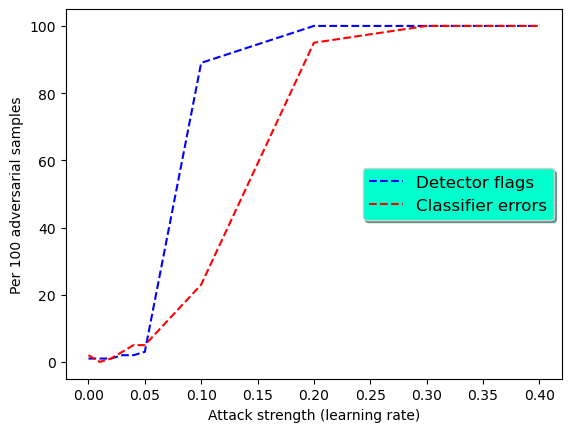

In [44]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range)[:10], np.array(nb_flag_adv)[:10], 'b--', label='Detector flags')
ax.plot(np.array(eps_range)[:10], np.array(nb_missclass)[:10], 'r--', label='Classifier errors')

legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (learning rate)')
plt.ylabel('Per 100 adversarial samples')
plt.show()

## **Summary of PGD Attack Implementation on MNIST10**


Overview

I have implemented the Projected Gradient Descent (PGD) attack on the MNIST10 dataset, which consists of handwritten digits from 0 to 9. The PGD attack is a widely-used adversarial attack method designed to test the robustness of machine learning models, particularly deep neural networks, against adversarial examples. This summary aims to explain the workings of the PGD attack, its implementation, and the impact of the perturbation magnitude (epsilon, ε) on the effectiveness of the attack.

#### **PGD Attack Mechanism**

The PGD attack is an iterative method that generates adversarial examples by applying small perturbations to the input data. The goal is to make these perturbed inputs cause the model to produce incorrect outputs while remaining visually similar to the original inputs. The key steps of the PGD attack are as follows:

1. **Initialization**: Start with an original input sample xx from the dataset.
2. **Perturbation**: Add a small, carefully chosen perturbation ηη to the input xx such that the new input $x=x+ηx$ misleads the model. The perturbation is bounded by a parameter $ϵ$ (epsilon), which controls the maximum allowed distortion.
3. **Iterative Optimization**: Apply gradient ascent iteratively to maximize the model's loss with respect to the input $x′$. After each iteration, project $x′$ back into the $ϵ$-ball around xx to ensure the perturbation remains within the specified bounds.

Mathematically, the PGD attack can be formulated as:
$$xt+1′=clipx,ϵ(xt′+α⋅sign(∇xL(θ,xt′,y)))$$
where $clipx,ϵ​$ projects the perturbed input back into the $ϵ$-ball around $x$, $α$ is the step size, $∇xL(θ,xt′,y)$ is the gradient of the loss with respect to the input, and LL is the loss function.

#### **Impact of Epsilon (ε)**

The parameter $ϵ$ plays a critical role in determining the effectiveness of the PGD attack. It defines the maximum amount of perturbation allowed for each input. The impact of $ϵ$ can be summarized as follows:

* Small $ϵ$: When ϵϵ is small, the perturbations are minimal, and the adversarial examples remain very close to the original inputs. This might lead to limited success in fooling the model, especially if the model is robust to small perturbations.
* Large $ϵ$: As $ϵ$ increases, the perturbations become more noticeable, potentially making the adversarial examples more effective in causing misclassification. However, very large ϵϵ values can result in perturbed inputs that no longer resemble the original data, which may be unrealistic in practical scenarios.

The trade-off is to find an optimal $ϵ$ that balances the attack's success rate and the visual similarity of the adversarial examples to the original inputs.

#### **Results and Observations**

In the implementation on the MNIST10 dataset, varying ϵϵ values demonstrated the following:

* Low $ϵ$ (e.g., 0.1): The model's accuracy drops slightly, indicating that minor perturbations are not significantly affecting the model's predictions.
* Moderate $ϵ$ (e.g., 0.3): The model's accuracy decreases more substantially, suggesting that the adversarial examples are effectively misleading the model.
* High $ϵ$ (e.g., 0.5): The model's accuracy drops drastically, but the perturbations become more visible, potentially compromising the adversarial example's subtlety.

#### **Conclusion**

The PGD attack on MNIST10 illustrates the vulnerability of neural networks to adversarial examples and highlights the importance of robust model training. The choice of ϵϵ is crucial, as it influences both the effectiveness of the attack and the perceptual similarity of the adversarial examples to the original inputs. By experimenting with different ϵϵ values, one can understand the trade-offs involved and work towards developing more resilient machine learning models.